In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Introduction
When insects such as ants leave the nest, for example as they look for food, they can take intricate paths on their scavenging journey. Behavioural experiments have shown that certain species of ants are capable of returning to their starting location in a straight line after roaming around for some time, even in the absence of landmark cues, suggesting that the ant has an internal representation or ‘memory’ of its location which updates based on the movement of the ant (Ziegler et al., 1997; Pisokas and Hennig, 2022).


In this project, we will be implementing a circuit capable of integrating the movement of the ant in two dimensions in order to obtain an estimate of its current position at every time step (Fig. 1). To do this, we will make use of the stability of bump attractors which you will implement yourselves using Poisson neurons. The project starts with some introductory exercises to get acquainted with simulating Poisson neurons and dealing with bump attractors. You will then continue to turn this bump attractor into a network capable of integration, before finally putting everything together at the end and simulating and decoding the trajectory of an agent.


Note: the project is intended to be solved using Python without the need for any specific library (other than the usual numpy and matplotlib). You are free to use other libraries if you want.

## Ex 0. Getting Started: Poisson neurons
In this project, we will be using Poisson neurons to simulate the neural activity. Their simplicity makes them a great candidate for efficiently simulating large scale population dynamics at the cost of some biological inaccuracies. Poisson neurons, as well as rate models in general, are described in more detail in the Neuronal Dynamics book in sections 7.2 and 15.3 respectively.
We use the following model for simulating the neurons. The potential $h_i$ (in mV) of every neuron $i$ evolves according to the differential equation

$$ \tau\frac{dh_{i}}{dt} (t) = −h_{i}(t) + RI_{i}(t)$$

where in the remaining we will take $R = 1M\Omega$. Every neuron has an instantaneous mean firing rate $r_i(t)$ given by the transfer function $g$, for which we will use the sigmoid function

$$r_{i}(t) = r_0g(h_i(t))=r_0\frac{1}{1+e^{-2\alpha(h_i(t)-\beta)}}$$

where $\alpha$ and $\beta$ are parameters for tuning the shape of the transfer function, and $r_0 = 1 ms^{−1}$.
In this model the spikes are generated according to a Poisson process, where the probability of having one spike in an interval $[t, t + \Delta t)$ is


$$P\{\text{spike in }[t,t+\Delta t)\}= r(t)\Delta t$$

**Network parameters.** Unless mentioned otherwise, we will be using the parameters $\alpha = 2$ $mV^{−1}$, $\beta = 0.5 mV$, $\Delta t = 0.1 ms$, $\tau = 10 ms$.
We start by examining the input-output relationship of the Poisson neurons.



**0.1.** Plot the transfer function $g$ as a function of the potential $h$. How do $\alpha$ and $\beta$ affect the shape?

In [36]:
# Define constants in standard units
R = 1e6 # Ohm
r_0 = 1e3 # Hz
alpha = 2e3 # 1/V
beta = 0.5e-3 # V
tau = 10e-3 # s
# Define ransfer function g
def transfer_g(h_i, alpha, beta):
    return 1/(1+np.exp(-2*alpha*(h_i - beta)))

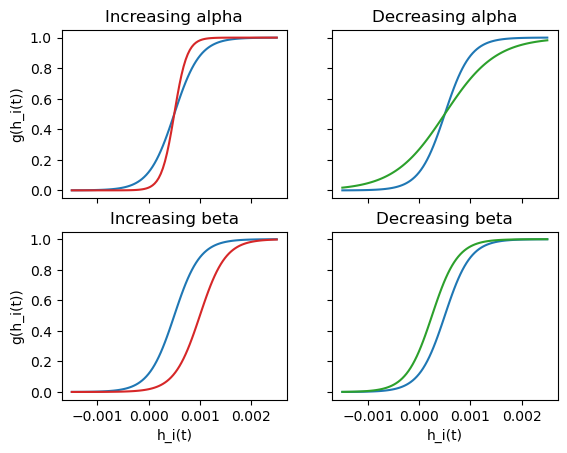

In [37]:
fig, axs = plt.subplots(2, 2)

x = np.linspace(-1.5e-3,2.5e-3, 100)

axs[0, 0].plot(x, transfer_g(x,alpha,beta))
axs[0, 0].plot(x, transfer_g(x,alpha*2,beta), 'tab:red')
axs[0, 0].set_title('Increasing alpha')
axs[0, 1].plot(x, transfer_g(x,alpha,beta))
axs[0, 1].plot(x, transfer_g(x,alpha*0.5,beta), 'tab:green')
axs[0, 1].set_title('Decreasing alpha')
axs[1, 0].plot(x, transfer_g(x,alpha,beta))
axs[1, 0].plot(x, transfer_g(x,alpha,beta*2), 'tab:red')
axs[1, 0].set_title('Increasing beta')
axs[1, 1].plot(x, transfer_g(x,alpha,beta))
axs[1, 1].plot(x, transfer_g(x,alpha,beta/2), 'tab:green')
axs[1, 1].set_title('Decreasing beta')

for ax in axs.flat:
    ax.set(xlabel='h_i(t)', ylabel='g(h_i(t))')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Alpha: increasing alpha makes the curve steeper, decreasing alpha makes it less steep.


Beta: horizontal shift, increasing beta shifts the curve to the right, decreasing it shifts it to the left.

**0.2.** Simulate the dynamics of $N = 100$ unconnected neurons for $T = 1000$ ms, receiving the slowly oscillating input $I_i(t) = I_0 sin(\omega t)$ with $I_0 = 2$ nA, $\omega = 10$ rad/s, and with all neurons initialised at $h_i(t=0)=0$ mV .

* Compare the mean number of spikes per ms across the $N$ neurons to the instantaneous rate $r = r_0g(RI(t))$. Explain the difference that you see.
* Now simulate $N = 1000$ neurons. Compare again as before, and explain the difference you see.

**Hints:**

* Write a method that runs the evolution of the membrane potentials, according to Eqs. (1) and (2). It should take as an argument the initial voltages $h_i(t = 0)$, and return all the voltages and spikes of the neurons through time.
* Eq. (1) can be integrated directly using the forward Euler method, with discrete time steps $t = t_0$, $t1$, ... $(t_k = k · \Delta t)$. It gives the following update rule:
  $$h_i(t_{k+1}) = h_i(t_k) + \Delta t · \frac{dh_i}{dt}(t_k)$$
* Combine spikes into bins of size 1ms, and scale accordingly to obtain an average firing rate.

In [65]:
# Define constants in standard units
T = 1 # s
I_0 = 2e-9 # A
omega = 10 # rad/s
delta_t = 1e-4 # s
def I_ex0(t):
    return I_0 * np.sin(omega*t)

def Euler_hi(h_i, delta_t, I):
    return h_i + (delta_t*(-h_i + R*I)/tau)

def Euler_hi_bis(h_i, delta_t, I, R, tau):
    return h_i + (delta_t*(-h_i + R*I)/tau)

In [39]:
def Model0(h0, N, T, delta_t):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate, it's the same for all neurons
            spikes[i,t] = np.random.choice([0,1], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]) # generate spikes
            if t != int(T/delta_t)-1:
                I_i = I_ex0(t)
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i) # update the voltage
    return h, spikes, r

In [40]:
"""
def Model1(h_i_0, I_0, N, T, delta_t):
    voltages = np.zeros(T)
    voltages[0] = h_i_0
    spikes = np.zeros((T,N)) 
    instant_rate1 = np.zeros(T) # Not sure wether to use the formula from the beginning (2)
    instant_rate2 = np.zeros(T) # or the one from 0.2

    for t in tqdm(range(T)): # Time steps
        for i in range(N): # neurons
            h_i_t_k = voltages[t]
            r_i_t = r_0 * transfer_g(h_i_t_k, alpha, beta)
            instant_rate1[t] = r_i_t
            instant_rate2[t] = r_0 * transfer_g((R*I_i(t)), alpha, beta)
            spike = np.random.choice([0,1], p=[1-(r_i_t*delta_t),r_i_t*delta_t])
            spikes[t][i] = spike
            h_i_t_k1 = Euler_h_i(h_i_t_k, t, delta_t)
            if t != T-1:
                voltages[t+1]=h_i_t_k1
    return voltages, spikes, instant_rate1, instant_rate2
    """

'\ndef Model1(h_i_0, I_0, N, T, delta_t):\n    voltages = np.zeros(T)\n    voltages[0] = h_i_0\n    spikes = np.zeros((T,N)) \n    instant_rate1 = np.zeros(T) # Not sure wether to use the formula from the beginning (2)\n    instant_rate2 = np.zeros(T) # or the one from 0.2\n\n    for t in tqdm(range(T)): # Time steps\n        for i in range(N): # neurons\n            h_i_t_k = voltages[t]\n            r_i_t = r_0 * transfer_g(h_i_t_k, alpha, beta)\n            instant_rate1[t] = r_i_t\n            instant_rate2[t] = r_0 * transfer_g((R*I_i(t)), alpha, beta)\n            spike = np.random.choice([0,1], p=[1-(r_i_t*delta_t),r_i_t*delta_t])\n            spikes[t][i] = spike\n            h_i_t_k1 = Euler_h_i(h_i_t_k, t, delta_t)\n            if t != T-1:\n                voltages[t+1]=h_i_t_k1\n    return voltages, spikes, instant_rate1, instant_rate2\n    '

In [41]:
"""
def avg_firing_rates(spikes, N, T = 100):
    averages = []
    for j in range(T):
        averages.append(np.sum(spikes[j])/N)
    return averages
"""

'\ndef avg_firing_rates(spikes, N, T = 100):\n    averages = []\n    for j in range(T):\n        averages.append(np.sum(spikes[j])/N)\n    return averages\n'

In [42]:
def avg_firing_rates(spikes, N, T, delta_t):
    averages = []
    for j in range(int(T/delta_t)):
        averages.append(np.sum(spikes[:, j])/N/delta_t)
    return averages

In [10]:
# 100 neurons
# vol_100, spik_100, irate1_100, irate2_100 = Model1(0,I_0,100,1000,delta_t)

In [11]:
# 1000 neurons
# vol_1000, spik_1000, irate1_1000, irate2_1000 = Model1(0,I_0,1000,1000,delta_t)

In [12]:
# print(np.mean(irate1_100), np.mean(irate2_100), np.mean(spik_100))

In [13]:
# Run simultation for 100 neurons
N = 100
h0 = 0
vol_100_bis, spik_100_bis, irate1_100_bis = Model0(h0,N,T,delta_t)

# Run simulation for 1000 neurons
N = 1000
h0 = 0
vol_1000_bis, spik_1000_bis, irate1_1000_bis = Model0(h0,N,T,delta_t)

100%|██████████| 10000/10000 [04:07<00:00, 40.44it/s]


## TODO : remove the second firing rate which is wrong

^ It seems that the instantaneous rate 1 is the one we should implement

In [26]:
"""
## Plot the difference between the instantaneous rate and the average rate of 100 vs 1000 neurons
plt.figure(figsize=(50,30))
avg_rates_100 = avg_firing_rates(spik_100,100)
plt.plot([i for i in range(T)], np.abs(irate1_100 - avg_rates_100), 'b')

avg_rates_1000 = avg_firing_rates(spik_1000,1000)
plt.plot([i for i in range(T)], np.abs(irate1_1000 - avg_rates_1000), 'r')
"""

"\n## Plot the difference between the instantaneous rate and the average rate of 100 vs 1000 neurons\nplt.figure(figsize=(50,30))\navg_rates_100 = avg_firing_rates(spik_100,100)\nplt.plot([i for i in range(T)], np.abs(irate1_100 - avg_rates_100), 'b')\n\navg_rates_1000 = avg_firing_rates(spik_1000,1000)\nplt.plot([i for i in range(T)], np.abs(irate1_1000 - avg_rates_1000), 'r')\n"

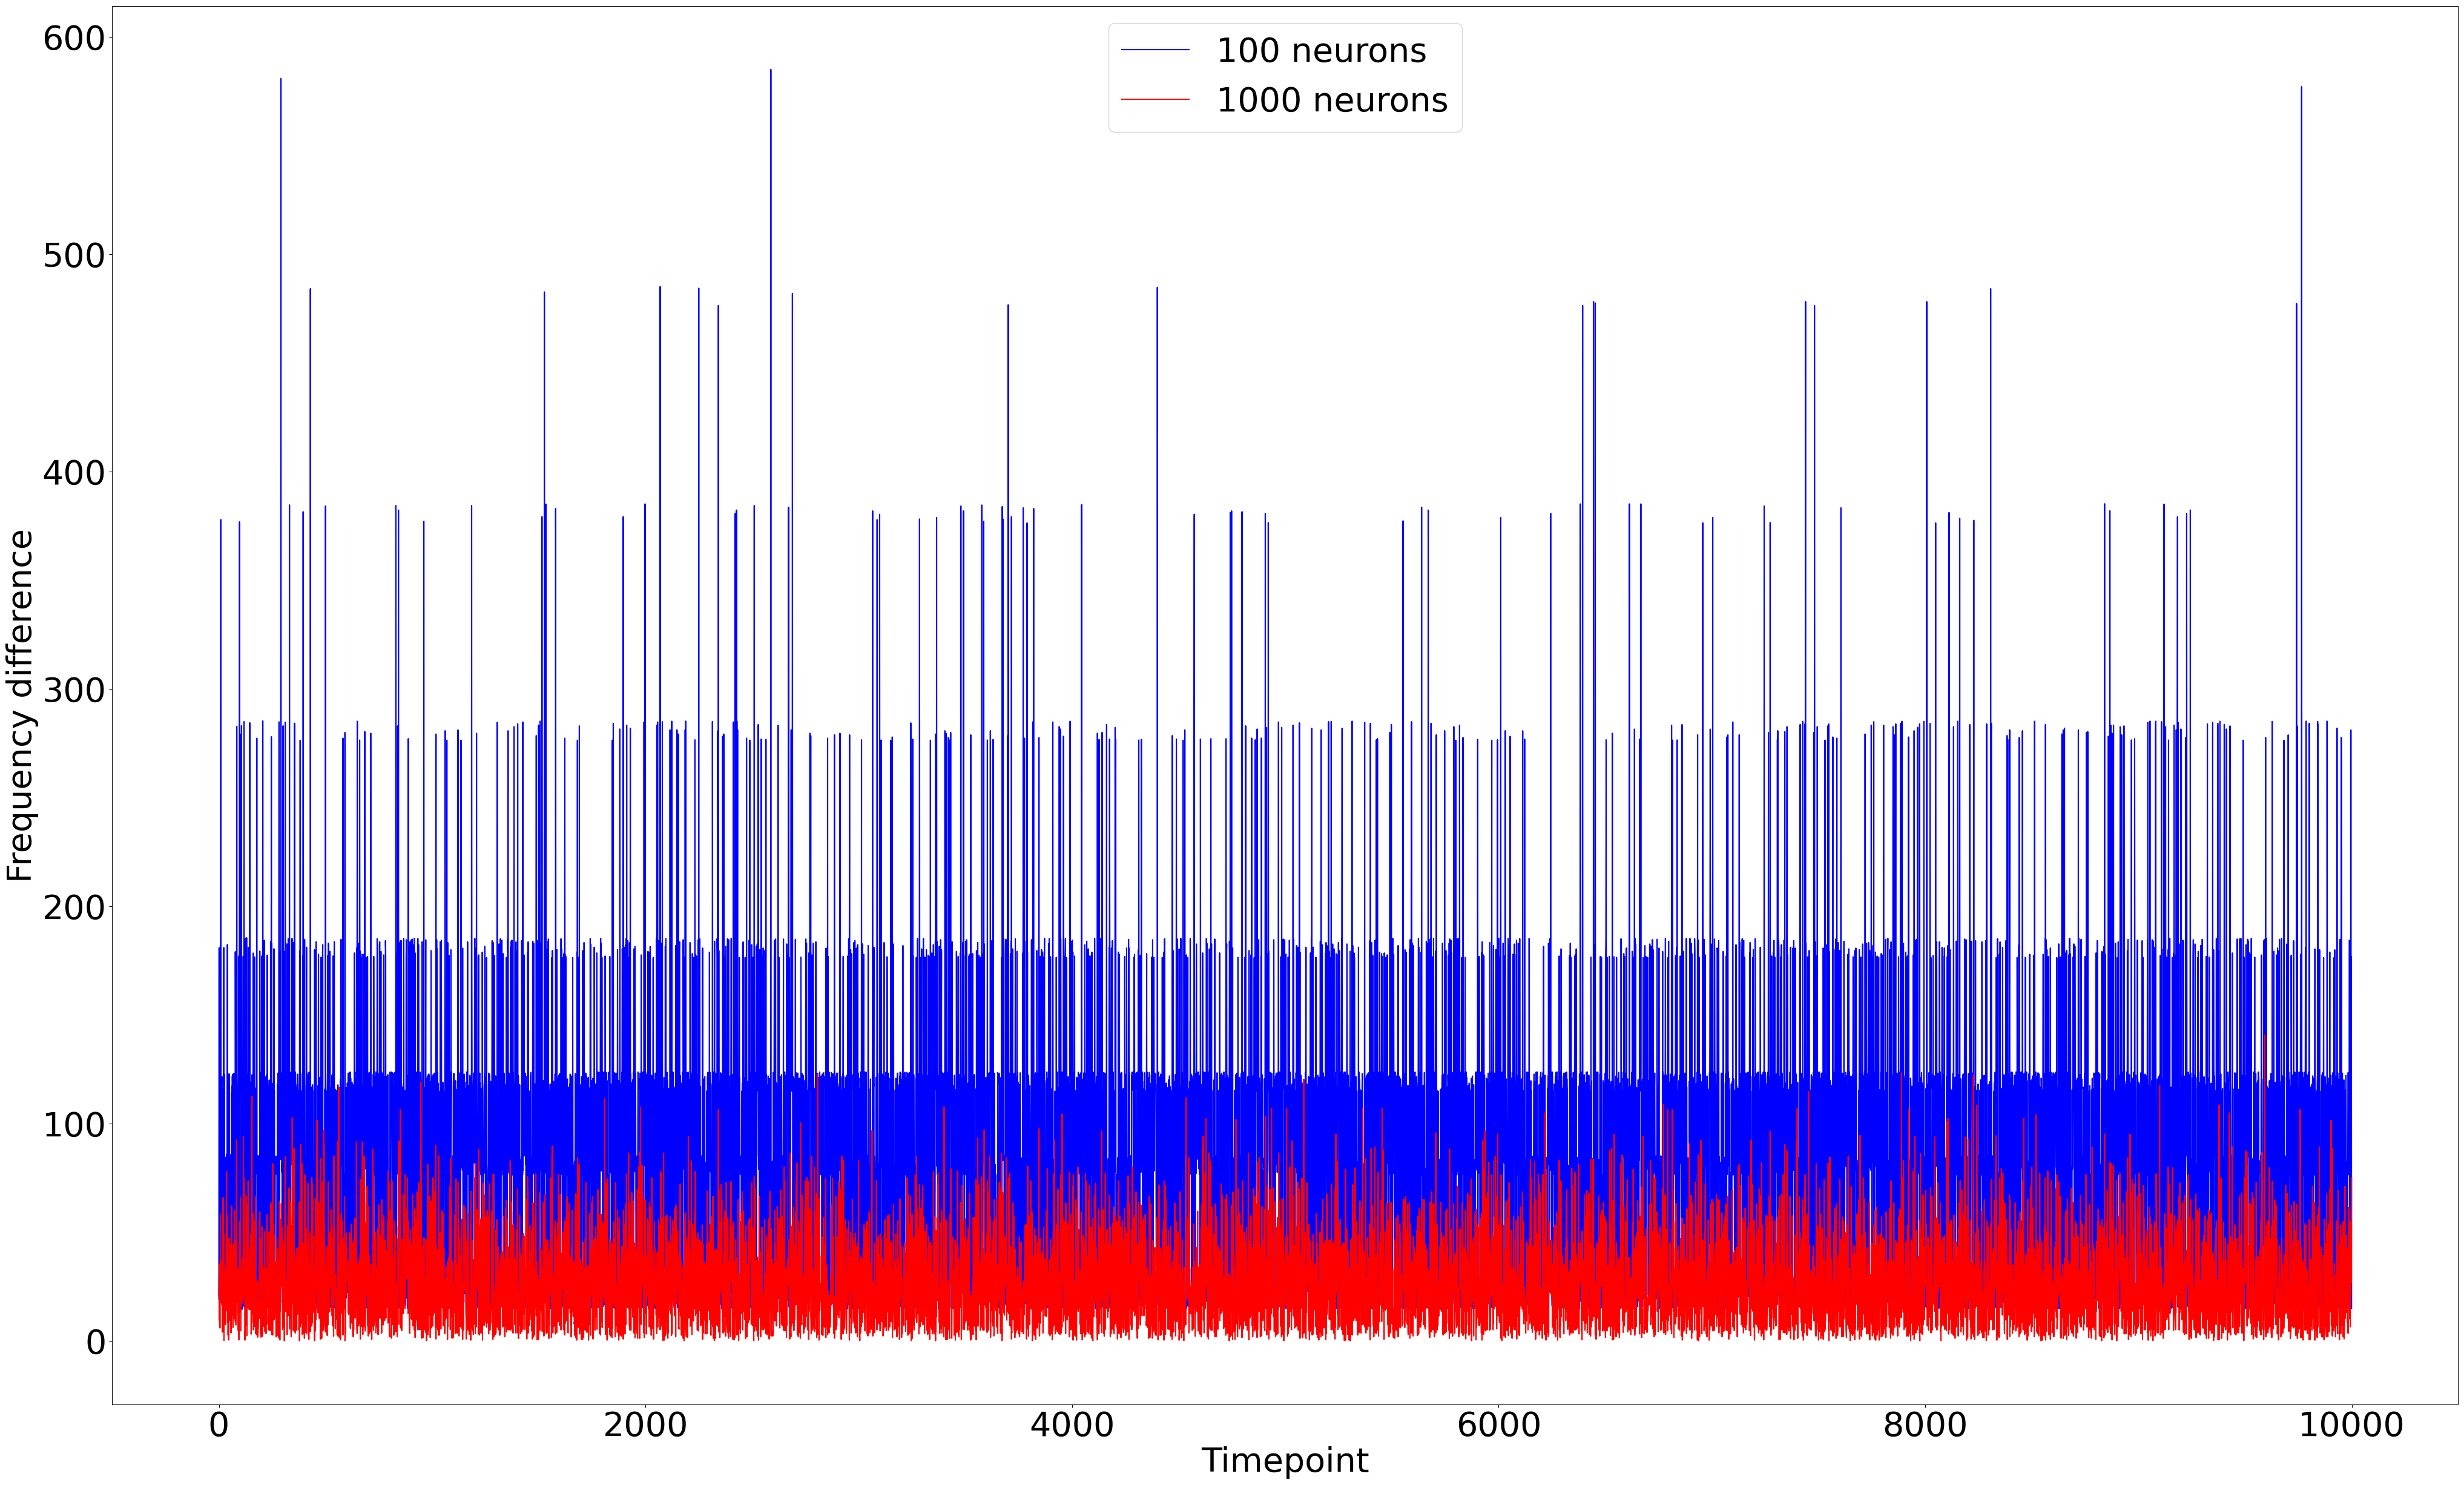

In [42]:
## Plot the difference between the instantaneous rate and the average rate of 100 vs 1000 neurons
plt.figure(figsize=(50,30))
avg_rates_100 = avg_firing_rates(spik_100_bis,100, T, delta_t)
plt.plot([i for i in range(int(T/delta_t))], np.abs(irate1_100_bis[0, :] - avg_rates_100), 'b', label = "100 neurons")

avg_rates_1000 = avg_firing_rates(spik_1000_bis,1000, T, delta_t)
plt.plot([i for i in range(int(T/delta_t))], np.abs(irate1_1000_bis[0, :] - avg_rates_1000), 'r', label = "1000 neurons")

plt.xlabel("Timepoint", fontsize = 40)
plt.ylabel("Frequency difference", fontsize = 40)

plt.xticks(fontsize=40)


plt.legend(fontsize = 40)
plt.show()

**Question answers:**

When looking at the above plot, we can see that, as expected, the more neurons the closer the average gets to the real value. Indeed, the difference between instantaneous rate and the average number of spikes per ms is due to the fact that the instantaneous rate is a constant, while the average number of spikes per ms is continuous and based on stochastic processes. The more neurons we have, the closer the average number of spikes per ms gets to the instantaneous rate as the number of generated spikes becomes less random.

## Ex 1. Bump attractor
Now that you know how to simulate Poisson neurons, we will use the equations from above to create a recurrent network to implement a bump attractor using N = 300 neurons. For this, we assign to each of our N neurons a position xi, equally spaced out over the range [0,2π). The input to each neuron i is defined through recurrent interactions and an external input, and is given by

$$I_{i}(t) = \frac{J}{N} \sum_{j=1}^{N}w(x_{i},x_{j})S_{j}(t) + I_{ext,i}(t)$$

$$w(x_{i},x_{j}) = cos(x_i - x_j)$$

where J (in picoCoulomb; pC) is the interaction strength, and $S_i(t)$ is the spike train of neuron i. It can be represented in discrete time as a variable taking value $S_i(t_k)$ = 1/∆t if there was a spike of neuron i in time step k.

**Decomposition of Recurrent Weights**   
The computational cost of computing the recurrent input as expressed in eq. (6) can be reduced from $O(N^2)$ to $O(N)$ by making use of the symmetries of the recurrent weights. The cosine of a difference can be decomposed as

$$cos(x_i - x_j) = cos(x_i)cos(x_j) + sin(x_i)sin(x_j)$$

From this, we can rewrite the recurrent input to each neuron as 

$$\frac{J}{N} \sum_{j=1}^{N}cos(x_{i} - x_{j})S_{j}(t) = \frac{J}{N}\sum_{j=1}^{N} \left[ cos(x_i)cos(x_j) + sin(x_i)sin(x_j)\right]S_j(t)$$
$$ = ...$$
$$ = J(cos(x_i)m_{cos}(t) + sin(x_i)m_{sin}(t))$$

with collective variable $m_{cos}(t) = \frac{1}{N}\sum_{j=1}^{N}cos(x_j)S_j(t)$, and similar for $m_{sin}(t)$ (analogous to the overlap variables in the Hopfield model). The computational cost is improved by computing these collective variables only once at each time step.

**1.1** Consider the recurrent network as described above with no external input, and simulate the dynamics. This time, take as initial condition for the potential values sampled from the uniform distribution between 0 and 1: $h_i$(0) ∼ Uniform(0,1) mV. Produce a raster plot of the activity. What values of J
 consistently produce a stable bump in the activity?

In [50]:
def Irecc_ex1(J, mcos, msin, xi):
    """
    Definition of the new equation for I_i(t) in ex.1.
    """
    return J*(mcos*np.cos(xi) + msin*np.sin(xi))

# Define new model for neurons
def Model1_1(h0, xs, N, T, delta_t, J, alpha, beta, r_0):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.sin(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spikes
                S[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i = Irecc_ex1(J, mcos, msin, xs[i]) # compute the new I_i for the input to next time step
                h[i,t+1] = Euler_hi(h[i,t], delta_t, I_i) # update the voltage for next time step
    return h, spikes, r

In [51]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 5e-12

# Compute neuron positions
x = np.linspace(0, 2*np.pi, N, endpoint=False)

# Compute initial voltages
h0 = np.random.uniform(0, 0.001, N)

# Run the simulation
h, spikes, r = Model1_1(h0, x, N, T, delta_t, J, alpha, beta, r_0)

100%|██████████| 10000/10000 [01:06<00:00, 151.19it/s]


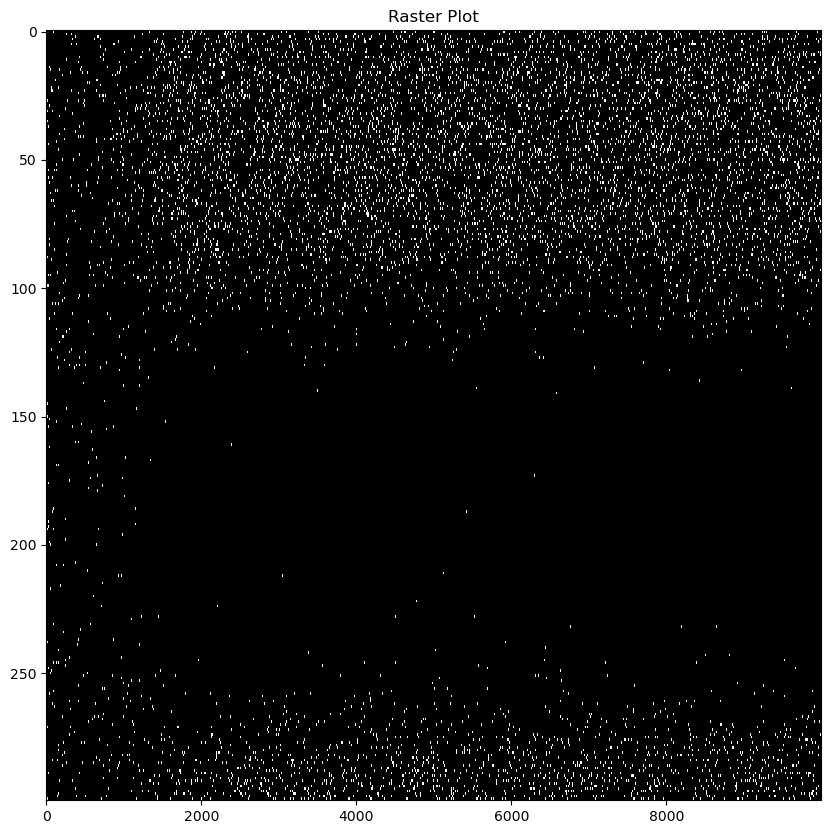

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(spikes, cmap='gray', interpolation='nearest', aspect="auto")
plt.title('Raster Plot')
plt.show()

**1.4.** Simulate the network with the external input described above, and create a rasterplot of the spikes. What is the effect of the input on the bump? How can this behaviour be explained by looking at the connectivity profile ?

In [90]:
# Define a function for the external current
def Iext_ex1(t, xi, T, delta_t):
    sigma = np.pi/8
    if t < 0.4*T/delta_t and t >= 0.3*T/delta_t:
        return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-((xi - 2*np.pi/3)**2)/(2*sigma**2))
    elif t < 0.7*T/delta_t and t >= 0.6*T/delta_t:
        return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-((xi - 4*np.pi/3)**2)/(2*sigma**2))
    else:
        return 0
    
# Define a model for question 1.4
def Model1_4(h0, xs, N, T, delta_t, J, alpha, beta, r_0, R, tau):
    n_timesteps = int(T/delta_t)
    h = np.zeros((N,n_timesteps)) # initialize voltages
    r = np.zeros((N,n_timesteps)) # initialize instant mean firing rates
    spikes = np.zeros((N,n_timesteps)) # initialize spikes matrix
    S = np.zeros((N, n_timesteps)) # initialize the spike train matrix
    h[:,0] = h0
    for t in tqdm(range(0,n_timesteps)): # time step
        # Compute mcos, msin. Works for t = 0 because S[:, -1] will be the current value of S for the last time step, so a row of zeros, which is what we want
        mcos = np.mean(np.sin(xs)*S[:, t-1]) 
        msin = np.mean(np.sin(xs)*S[:, t-1])
        for i in range(N): # neurons
            r[i,t] = r_0 * transfer_g(h[i,t-1], alpha, beta) # calculate the mean firing rate
            if np.random.choice([False,True], p=[1-(r[i,t]*delta_t),r[i,t]*delta_t]): # generate spikes
                spikes[i,t] = 1 # add spikes
                S[i, t] = 1/delta_t # add spike train
            if t != int(T/delta_t)-1:
                I_i = Irecc_ex1(J, mcos, msin, xs[i]) + Iext_ex1(t, xs[i], T, delta_t) # compute the new I_i for the input to next time step
                h[i,t+1] = Euler_hi_bis(h[i,t], delta_t, I_i, R, tau) # update the voltage for next time step
    return h, spikes, r

In [91]:
# Define parameters
N = 300
T = 1
delta_t = 1e-4
alpha = 2e3
beta = 0.5e-3
r_0 = 1e3
J = 5e-12
R = 1e6
tau = 10e-3

# Compute initial voltages
h0 = np.random.uniform(0, 1e-3, N)

# Run the simulation
h, spikes, r = Model1_4(h0, x, N, T, delta_t, J, alpha, beta, r_0, R, tau)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:15<00:00, 133.01it/s]


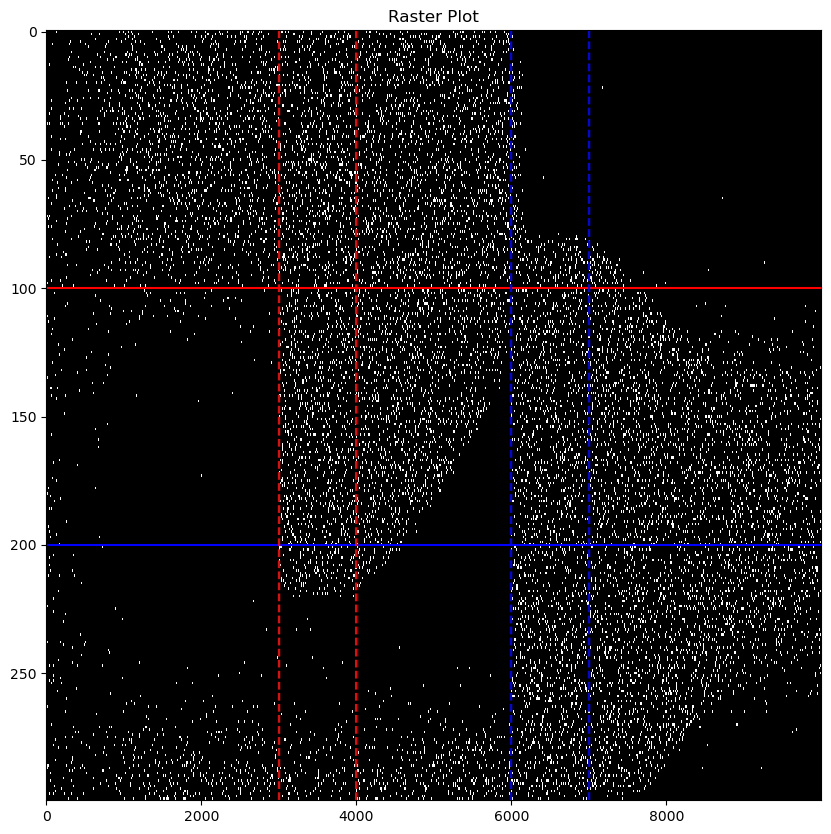

In [92]:
plt.figure(figsize=(10,10))
plt.imshow(spikes, cmap='gray', interpolation='nearest', aspect="auto")
plt.axhline(y = int(300/3), color = 'r')
plt.axhline(y = int(300/3*2), color = 'b')
plt.axvline(x = 3000, color = 'r', linestyle='--') 
plt.axvline(x = 4000, color = 'r', linestyle='--')
plt.axvline(x = 6000, color = 'b', linestyle='--') 
plt.axvline(x = 7000, color = 'b', linestyle='--')
plt.title('Raster Plot')
plt.show()

We can see from the above rasterplot that the external input shifts the bump to a particular location. This is easily explained by the connectivity profile, which is a function of the sine and cosine of the difference between the positions of the neurons. On its own, this connectivity profile makes sure that neurons that are activated form a group and inhibit the neurons that are further away. Adding the external input, which is strongest around some neurons' positions and much stronger than the natural input to the neurons, shifts the activity bump around the predetermined positions.

**1.5.** In the case without external input, what would happen to the bump if the connectivity was instead given by $w(x_i − \phi,x_j)$, with $\phi$ a small angle? Explain the behaviour you would expect, and verify it through a simulation.

**Hint** This recurrent connectivity can again be implemented using the collective variables mcos and msin from before, but with slightly different terms in front.